>>> RANDOM FOREST + LASSO FEATURE SELECTION İŞLEMİ BAŞLATILIYOR...

Veri Temizliği Tamamlandı. Veri Boyutu: (638454, 12)

>>> LASSO İLE ÖZELLİK SEÇİMİ YAPILIYOR...
Lasso Tarafından Seçilen Özellik Sayısı: 11
Lasso Tarafından Elenen Özellik Sayısı: 0


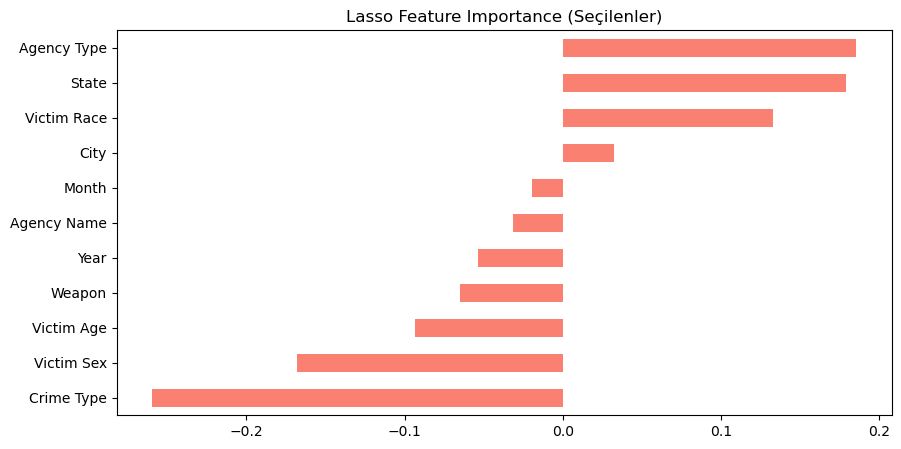


>>> RANDOM FOREST MODELİ EĞİTİLİYOR (Seçilmiş Özelliklerle)...
Random Forest Eğitimi Tamamlandı.

       MODEL PERFORMANS RAPORU (RF + LASSO)       
Model: Random Forest Classifier
Feature Selection: LASSO (L1)
--------------------------------------------------
1. Accuracy (Doğruluk):      0.7323
2. ROC AUC Score:            0.7270
3. Cohen's Kappa:            0.2953
4. Log Loss:                 0.5831
--------------------------------------------------

Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.39      0.47     37875
           1       0.77      0.88      0.82     89816

    accuracy                           0.73    127691
   macro avg       0.67      0.63      0.64    127691
weighted avg       0.71      0.73      0.72    127691



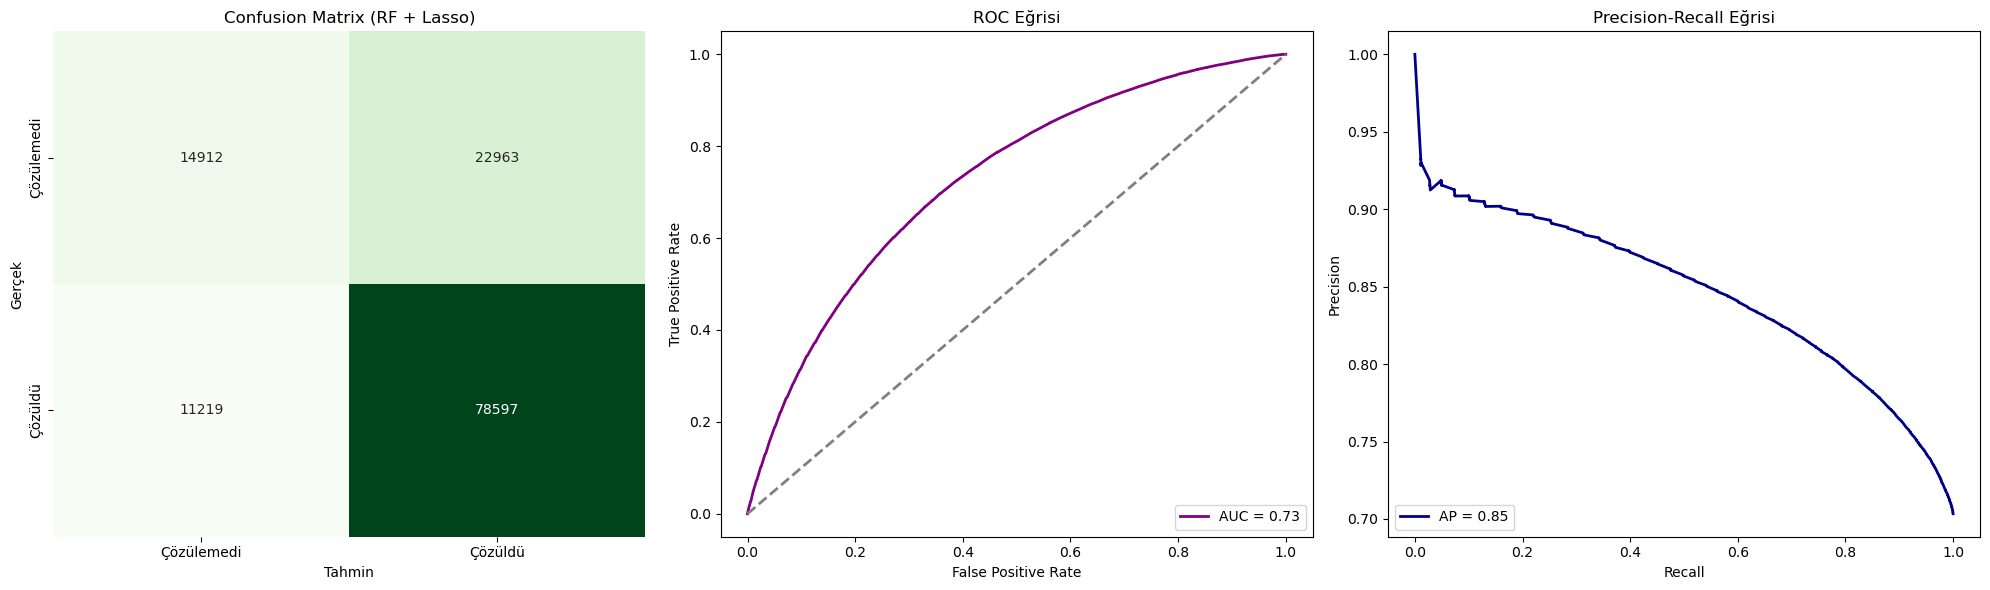

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Gerekli Kütüphaneler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve, 
                             average_precision_score, log_loss, cohen_kappa_score)

warnings.filterwarnings('ignore')

print(">>> RANDOM FOREST + LASSO FEATURE SELECTION İŞLEMİ BAŞLATILIYOR...\n")

# ---------------------------------------------------------
# 1. ADIM: VERİ YÜKLEME VE TEMİZLİK
# ---------------------------------------------------------
df = pd.read_csv('US_Crime_DataSet.csv', low_memory=False)

# Leakage Önleme (Fail Bilgilerini Atma)
cols_to_drop = [
    'Record ID', 'Agency Code', 'Incident', 'Record Source',
    'Victim Ethnicity', 'Victim Count',
    'Perpetrator Ethnicity', 'Perpetrator Count',
    'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race', 'Relationship'
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Target Dönüşümü
df['Crime Solved'] = df['Crime Solved'].map({'Yes': 1, 'No': 0})

# Yaş Temizliği
df['Victim Age'] = pd.to_numeric(df['Victim Age'], errors='coerce')
df.loc[(df['Victim Age'] > 99) | (df['Victim Age'] == 0), 'Victim Age'] = np.nan
df['Victim Age'] = df['Victim Age'].fillna(df['Victim Age'].median())

# Encoding
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

print("Veri Temizliği Tamamlandı. Veri Boyutu:", df.shape)

# ---------------------------------------------------------
# 2. ADIM: FEATURE SELECTION - LASSO (L1 Regularization)
# ---------------------------------------------------------
print("\n>>> LASSO İLE ÖZELLİK SEÇİMİ YAPILIYOR...")

X = df.drop('Crime Solved', axis=1)
y = df['Crime Solved']

# Lasso için feature'ları ölçeklendiriyoruz
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Lasso Modeli (L1 cezası ile gereksizleri sıfırlar)
# C=0.01 diyerek elemeyi biraz sertleştiriyoruz (Gereksizleri atması için)
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.05, random_state=42)
lasso.fit(X_scaled, y)

# Seçilenleri Belirle
coefs = pd.Series(lasso.coef_[0], index=X.columns)
selected_features = coefs[coefs != 0].index.tolist()
removed_features = coefs[coefs == 0].index.tolist()

print(f"Lasso Tarafından Seçilen Özellik Sayısı: {len(selected_features)}")
print(f"Lasso Tarafından Elenen Özellik Sayısı: {len(removed_features)}")
if len(removed_features) > 0:
    print(f"Elenen Sütunlar: {removed_features}")

# Lasso Katsayılarını Görselleştir (Hocaya göstermek için güzel bir grafik)
plt.figure(figsize=(10, 5))
coefs[selected_features].sort_values().plot(kind='barh', color='salmon')
plt.title("Lasso Feature Importance (Seçilenler)")
plt.show()

# Veriyi SADECE SEÇİLEN sütunlarla güncelle
X_selected = df[selected_features]

# ---------------------------------------------------------
# 3. ADIM: MODELLEME - RANDOM FOREST
# ---------------------------------------------------------
print("\n>>> RANDOM FOREST MODELİ EĞİTİLİYOR (Seçilmiş Özelliklerle)...")

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Random Forest Modeli
rf_model = RandomForestClassifier(n_estimators=100, 
                                  random_state=42, 
                                  class_weight='balanced', 
                                  n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Eğitimi Tamamlandı.")

# ---------------------------------------------------------
# 4. ADIM: KAPSAMLI RAPORLAMA
# ---------------------------------------------------------
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
logloss = log_loss(y_test, y_pred_proba)
kappa = cohen_kappa_score(y_test, y_pred)

print("\n" + "="*50)
print("       MODEL PERFORMANS RAPORU (RF + LASSO)       ")
print("="*50)
print(f"Model: Random Forest Classifier")
print(f"Feature Selection: LASSO (L1)")
print("-" * 50)
print(f"1. Accuracy (Doğruluk):      {accuracy:.4f}")
print(f"2. ROC AUC Score:            {roc_auc:.4f}")
print(f"3. Cohen's Kappa:            {kappa:.4f}")
print(f"4. Log Loss:                 {logloss:.4f}")
print("-" * 50)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
print("="*50)

# --- GRAFİKLER ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix (RF + Lasso)')
axes[0].set_xlabel('Tahmin')
axes[0].set_ylabel('Gerçek')
axes[0].set_xticklabels(['Çözülemedi', 'Çözüldü'])
axes[0].set_yticklabels(['Çözülemedi', 'Çözüldü'])

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='purple', lw=2, label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Eğrisi')
axes[1].legend(loc="lower right")

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
axes[2].plot(recall, precision, color='darkblue', lw=2, label=f'AP = {avg_precision:.2f}')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Eğrisi')
axes[2].legend(loc="lower left")

plt.tight_layout()
plt.show()